- Make learner work generically

- Make it work with add_col=True
- Make it work with n_jobs > 1

In [1]:
#default_exp tabular_api

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#export
from hypster.oo_hp import *
from hypster.hypster_prepare import *

import fastai2
from fastai2.tabular.all import *
from fastai2.metrics import *

from sklearn.model_selection import train_test_split

from copy import deepcopy

import optuna

In [4]:
#export
SEED = 42

# Read Data

In [5]:
#export
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('C:/Users/user/.fastai/data/adult_sample/adult.csv'),Path('C:/Users/user/.fastai/data/adult_sample/export.pkl'),Path('C:/Users/user/.fastai/data/adult_sample/models')]

In [6]:
#export
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [7]:
#export
df = df.sample(frac=0.1)

In [8]:
#export
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
dep_var = "salary"

In [9]:
#export
train_df, test_df = train_test_split(df, test_size=0.6, 
                                     random_state=SEED, 
                                     stratify=df[dep_var])

# Preprocessing

In [10]:
FillMissing = prepare(FillMissing)

In [11]:
fill_strategy = HpCategorical([FillStrategy.mode, 
                               FillStrategy.median, 
                               #FillStrategy.constant(5, fill)
                              ])

In [12]:
#imp = FillMissing(fill_strategy=fill_strategy, add_col=HpBool("add_col"))

In [13]:
imp = FillMissing(fill_strategy=fill_strategy, add_col=False)

In [14]:
#export
Normalize = prepare(Normalize)
norm = Normalize(mean=HpFloat(0.001, 10.4))

In [15]:
#export
procs = [Categorify, imp, HpToggle(norm)]

# DataBunch

In [16]:
import fastai2

In [17]:
TabularPandas = prepare(fastai2.tabular.data.TabularPandas)

In [18]:
#export
to = TabularPandas(train_df,
                   y_block = CategoryBlock(), 
                   y_names = dep_var,
                   splits = RandomSplitter()(range_of(train_df)),
                   cat_names = cat_names,
                   cont_names = cont_names,
                   procs = procs,
                   reduce_memory=False,
                   inplace=False
                  )

In [19]:
#export
#dls = to.dataloaders(batch_size=2 ** HpInt("batch_size", 5, 9))
#dls = to.dataloaders(batch_size=HpInt("batch_size", 16, 128, 16))

In [20]:
#export
dls = to.dataloaders(batch_size=32)

# Learner

In [21]:
#export
cbs = [TrackerCallback(monitor="roc_auc_score"), 
       ReduceLROnPlateau("roc_auc_score", patience=3)]

In [22]:
#export
start_mom = HpFloat(0.85, 0.99)

In [23]:
#export
tabular_learner = prepare(tabular_learner)

In [24]:
#export
learner = tabular_learner(dls,
                          metrics=RocAuc(),
                          opt_func=HpCategorical([Adam, SGD, QHAdam]),
                          layers=HpVarLenList(1, 4, HpInt(50, 300, 50, name="layer_size"), same_value=False),
                          cbs=cbs,
                          moms=(start_mom, start_mom-0.1, start_mom), 
                          wd_bn_bias=HpBool(),
                          )

# Optuna

In [25]:
lr = HpFloat(1e-5, 1e-1, log=True)

In [26]:
def lr_finder(trial, learner, lr_type="steep", **kwargs):
    #TODO: remove trial?
    learner = learner.sample(trial)
    lr_min, lr_steep = learner.lr_find(**kwargs)
    if lr_type == "steep":
        return lr_steep
    else:
        return lr_min * 0.1

In [27]:
lr = HpFunc(lr_finder, learner=learner, lr_type=HpCategorical(["min", "steep"]))

In [28]:
import datetime

In [29]:
#export
def run_learner(learner, fit_method, get_metric, n_trials=5): #learner
    class Objective():
        def __init__(self, fit_method, get_metric): #learner
            #self.learner   = learner
            self.fit_method = fit_method
            self.get_metric = get_metric
            
        def __call__(self, trial): 
            #learner = self.learner.sample(trial)
            self.fit_method.sample(trial)
            res = self.get_metric.sample(trial)
            #print(self.fit_method.base_call)
            #print(self.get_metric.base_call.base_call)
            print(res)
            return res
       
    objective = Objective(fit_method, get_metric) #learner
    optuna.logging.set_verbosity(0)
    pruner = optuna.pruners.NopPruner()
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    study = optuna.create_study(direction="maximize", study_name = now, pruner=pruner)
    
    #study.set_user_attr("names_db", {}) #TODO: Check what happens if n_jobs=-1
    #set_names(learner, fit_method, get_metric, study)
    
    study.optimize(objective, n_trials=n_trials, n_jobs=1, timeout=600)
    return study

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.576886,0.636548,0.497487,00:00
1,0.497265,0.583661,0.497487,00:00


0.49748743718592964


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.559102,0.627220,0.500000,00:00
1,0.512345,0.577873,0.524590,00:00


0.5245901639344263


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.556154,0.654644,0.622003,00:00
1,0.479795,0.595610,0.683870,00:00


0.683870170524755


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.561387,0.635919,0.500000,00:00
1,0.475152,0.541577,0.665912,00:00


0.6659115248373013


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.574861,0.676084,0.713321,00:00
1,0.483603,0.619577,0.753934,00:00


0.7539336024384214


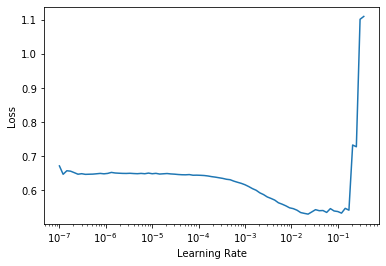

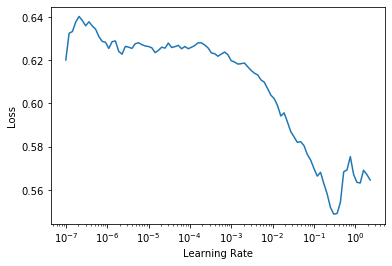

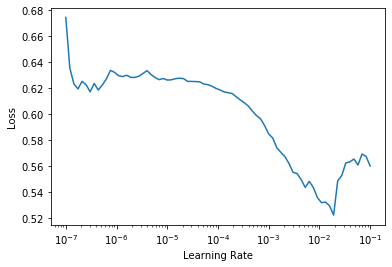

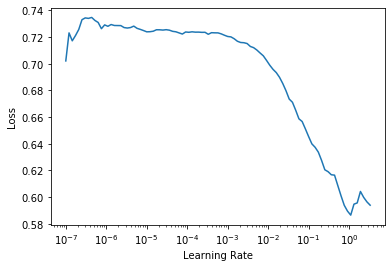

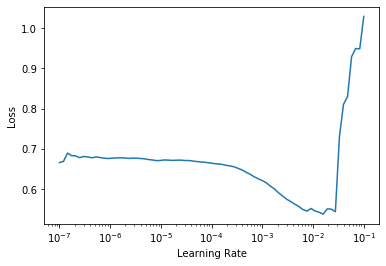

In [30]:
#export
study = run_learner(learner    = learner,
                    fit_method = learner.fit_one_cycle(2, lr),
                    get_metric = learner.tracker.best,
                    n_trials   = 5
                   )

In [31]:
#export
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 5


In [32]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

Best trial:
  Value: 0.7539336024384214


In [33]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    fill_strategy: median
    toggle_HypsterPrepare: False
    opt_func: QHAdam
    layers: 4
    layer_size_1: 300
    layer_size_2: 200
    layer_size_3: 150
    layer_size_4: 250
    float: 0.8749153290193485
    wd_bn_bias: False


In [34]:
study.trials[0].params

{'fill_strategy': 'median',
 'toggle_HypsterPrepare': False,
 'opt_func': 'Adam',
 'layers': 3,
 'layer_size_1': 250,
 'layer_size_2': 50,
 'layer_size_3': 250,
 'float': 0.9567640263388554,
 'wd_bn_bias': False}

In [35]:
#export
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,params_fill_strategy,params_float,params_layer_size_1,params_layer_size_2,params_layer_size_3,params_layer_size_4,params_layers,params_mean,params_opt_func,params_toggle_HypsterPrepare,params_wd_bn_bias,user_attrs_func,state
0,0,0.497487,2020-06-06 22:35:23.558487,2020-06-06 22:35:26.314487,median,0.956764,250,50.0,250.0,NaN,3,NaN,Adam,False,False,0.000229,COMPLETE
1,1,0.524590,2020-06-06 22:35:26.315487,2020-06-06 22:35:28.410486,mode,0.906933,250,NaN,NaN,NaN,1,NaN,SGD,False,False,0.003020,COMPLETE
2,2,0.683870,2020-06-06 22:35:28.411486,2020-06-06 22:35:31.467486,median,0.986715,200,250.0,100.0,NaN,3,NaN,QHAdam,False,True,0.000191,COMPLETE
3,3,0.665912,2020-06-06 22:35:31.468486,2020-06-06 22:35:33.549489,median,0.899998,150,NaN,NaN,NaN,1,4.59022,SGD,True,False,0.010965,COMPLETE
4,4,0.753934,2020-06-06 22:35:33.551486,2020-06-06 22:35:37.554491,median,0.874915,300,200.0,150.0,250.0,4,NaN,QHAdam,False,False,0.000158,COMPLETE


In [36]:
from nbdev.export import notebook2script

In [37]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_api.ipynb.
Converted 02_oo_hp.ipynb.
Converted 03_hypster_prepare.ipynb.
Converted 04_tabular_api.ipynb.
Converted 05_sklearn.ipynb.
Converted fastai_adult_tutorial.ipynb.
Converted index.ipynb.
